## Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import warnings


import pandas as pd
import numpy as np
import os

import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim

import torch.nn as nn
import torchvision.datasets as dsets

import zipfile  # unziping 
import glob  # finding image paths
import numpy as np  # creating numpy arrays
from skimage.io import imread  # reading images
from skimage.transform import resize  # resizing images

import PIL
import random
from pathlib import Path

#!pip install torchsummary
#from torchsummary import summary

!pip install torchviz
from torchviz import make_dot, make_dot_from_trace


warnings.filterwarnings('ignore')

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=bb881c980a6ef666d6b193b963ebce7037cd1db168e7f6bf672496b6f2c95eb5
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


# Download and unzip

In [ ]:
!gdown --id '1xvdl_w2gVoOyIh7jAy2jBbXUkQOSVksY'

Downloading...
From: https://drive.google.com/uc?id=1xvdl_w2gVoOyIh7jAy2jBbXUkQOSVksY
To: /content/CSE4238_SoftComputing_Assignment_2_training-a.zip
816MB [00:04, 168MB/s]


In [ ]:
!unzip '/content/CSE4238_SoftComputing_Assignment_2_training-a.zip'

Streaming output truncated to the last 5000 lines.
  inflating: CSE4238_SoftComputing_Assignment_2_training-a/a14702.png  
  inflating: CSE4238_SoftComputing_Assignment_2_training-a/a14703.png  
  inflating: CSE4238_SoftComputing_Assignment_2_training-a/a14704.png  
  inflating: CSE4238_SoftComputing_Assignment_2_training-a/a14705.png  
  inflating: CSE4238_SoftComputing_Assignment_2_training-a/a14706.png  
  inflating: CSE4238_SoftComputing_Assignment_2_training-a/a14707.png  
  inflating: CSE4238_SoftComputing_Assignment_2_training-a/a14708.png  
  inflating: CSE4238_SoftComputing_Assignment_2_training-a/a14709.png  
  inflating: CSE4238_SoftComputing_Assignment_2_training-a/a14710.png  
  inflating: CSE4238_SoftComputing_Assignment_2_training-a/a14711.png  
  inflating: CSE4238_SoftComputing_Assignment_2_training-a/a14712.png  
  inflating: CSE4238_SoftComputing_Assignment_2_training-a/a14713.png  
  inflating: CSE4238_SoftComputing_Assignment_2_training-a/a14714.png  
  inflating: 

In [ ]:
!rm '/content/CSE4238_SoftComputing_Assignment_2_training-a.zip'
print("removed")

removed


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Datasets/CSE4238_SoftComputing_Assignment_2_training-a.csv")
df = df.loc[:, ['filename','digit']]

# Data PreProcessing

In [ ]:
class processDataset(Dataset):

    def __init__(self, root, image_dir, csv_file, transform=None):
        self.root = root
        self.image_dir = image_dir
        self.image_files = csv_file.iloc[:, 0]
        self.data = csv_file.iloc[:, 1]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_name = os.path.join(self.image_dir, self.image_files[index])
        image = PIL.Image.open(image_name)
        label = self.data[index]
        if self.transform:
            image = self.transform(image)
        return (image, label)

In [ ]:
root = Path(os.getcwd())
image_dir = root/'CSE4238_SoftComputing_Assignment_2_training-a'
csv_file = df
transform_img = transforms.Compose([
                            transforms.Grayscale(),
                            transforms.Resize(28),
                            transforms.CenterCrop(28),
                            transforms.ToTensor()
])

In [ ]:
dset = processDataset(root, image_dir, csv_file, transform= transform_img)
dset_size = len(dset)
test_perc = 20
test_size = int(dset_size * (test_perc/100))
train_size = dset_size - test_size
train_dataset, test_dataset = torch.utils.data.random_split(dset, [train_size, test_size])

In [ ]:
print(dset_size, test_size, train_size)

19702 3940 15762


# EDA

In [ ]:
df1 = pd.read_csv("/content/drive/MyDrive/Datasets/CSE4238_SoftComputing_Assignment_2_training-a.csv")
df1=df1[["digit"]]
x_label_data=df1.to_numpy()
(unique, counts) = np.unique(x_label_data, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[   0 1975]
 [   1 1963]
 [   2 1984]
 [   3 1976]
 [   4 1982]
 [   5 1965]
 [   6 1983]
 [   7 1960]
 [   8 1950]
 [   9 1964]]


Label: 5
Label: 8
Label: 8
Label: 4
Label: 9
Label: 7
Label: 7
Label: 3


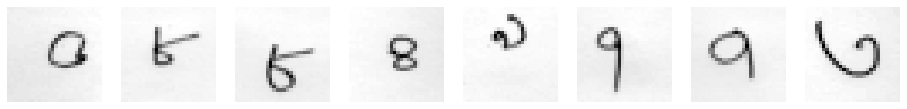

In [ ]:
def get_image(image, label, dataset):
    print(f"Label: {label}")
    image = image.permute(1,2,0)
    image = image[:,:,0]
    # plt.imshow(image,cmap='gray')
    # plt.show()
    return image
plt.rcParams['figure.figsize'] = (16, 2)
for i in range(1,9):
  img = get_image(*train_dataset[i], train_dataset)
  plt.subplot(1, 8, i)
  plt.axis('off')
  plt.imshow(img,cmap='gray')
plt.show()


# Model 1

In [ ]:
#device
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
#print('Using {} device'.format(device))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Hyperparameters
batch_size = 20
num_iters = 20000
input_dim = 28*28
output_dim = 10
learning_rate = 0.01

In [ ]:
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear_1 = nn.Linear(input_size, 75)
        self.relu_1 = nn.ReLU()

        self.linear_2 = nn.Linear(75, 45)
        self.relu_2 = nn.ReLU()

        self.linear_3 = nn.Linear(45, 30)
        self.relu_3 = nn.ReLU()

        self.linear_4 = nn.Linear(30, 20)
        self.relu_4 = nn.ReLU()

        self.linear_5 = nn.Linear(20, 16)
        self.relu_5 = nn.ReLU()

        self.linear_6 = nn.Linear(16, 14)
        self.relu_6 = nn.ReLU()

        self.linear_out = nn.Linear(14, num_classes)

    def forward(self, x):
        
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)

        out  = self.linear_3(out)
        out = self.relu_3(out)

        out  = self.linear_4(out)
        out = self.relu_4(out)

        out  = self.linear_5(out)
        out = self.relu_5(out)

        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iter = 0
test_loss_min = 9999999
iter_data,train_loss_data, test_loss_data, acc_data = [], [], [], []

for epoch in range(num_epochs):
    train_loss = 0.0
    test_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, input_dim).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, input_dim).to(device)
                labels = labels.to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                loss = criterion(outputs, labels)

                test_loss += loss.item() * images.size(0)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            train_loss = train_loss / len(train_loader.dataset)
            test_loss = test_loss / len(test_loader.dataset)
            train_loss_data.append(train_loss)
            test_loss_data.append(test_loss)
            accuracy = 100 * correct.item() / total
            acc_data.append(accuracy)
            iter_data.append(iter)

            # Print Loss
            print('Iteration: {}. Train_Loss: {}. Valid_Loss: {}. Accuracy: {}'.format(iter, train_loss, test_loss, accuracy))

            if test_loss <= test_loss_min:
              #print('***Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...***'.format(test_loss_min,test_loss))
              torch.save(model.state_dict(), 'EXP_01.pt')
              test_loss_min = test_loss


Iteration: 500. Train_Loss: 1.4636430848054724. Valid_Loss: 2.3061375388034104. Accuracy: 8.857868020304569
Iteration: 1000. Train_Loss: 0.6167685829765708. Valid_Loss: 2.304233042721821. Accuracy: 8.857868020304569
Iteration: 1500. Train_Loss: 1.4611604049283327. Valid_Loss: 2.304692580244143. Accuracy: 8.857868020304569
Iteration: 2000. Train_Loss: 1.2330038437699926. Valid_Loss: 2.3040511051410344. Accuracy: 8.857868020304569
Iteration: 2500. Train_Loss: 0.3886240739656605. Valid_Loss: 2.303808368402084. Accuracy: 8.857868020304569
Iteration: 3000. Train_Loss: 1.4608696028222703. Valid_Loss: 2.30442140626755. Accuracy: 8.857868020304569
Iteration: 3500. Train_Loss: 1.00511001521085. Valid_Loss: 2.303399725008737. Accuracy: 8.857868020304569
Iteration: 4000. Train_Loss: 0.16065423311035792. Valid_Loss: 2.3039807329323088. Accuracy: 8.857868020304569
Iteration: 4500. Train_Loss: 1.4608843321530465. Valid_Loss: 2.304588259513249. Accuracy: 8.857868020304569
Iteration: 5000. Train_Loss:

## Loss Graph

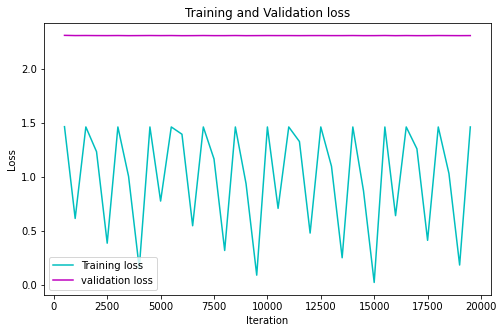

In [ ]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.plot(iter_data, train_loss_data, 'c', label='Training loss')
plt.plot(iter_data, test_loss_data, 'm', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy Graph

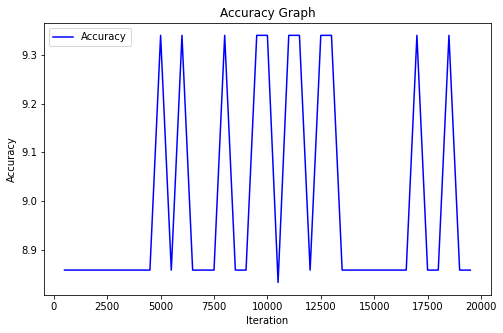

In [ ]:
plt.plot(iter_data, acc_data, 'b', label='Accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Model visualization

In [ ]:
print(torch.cuda.device_count())

1


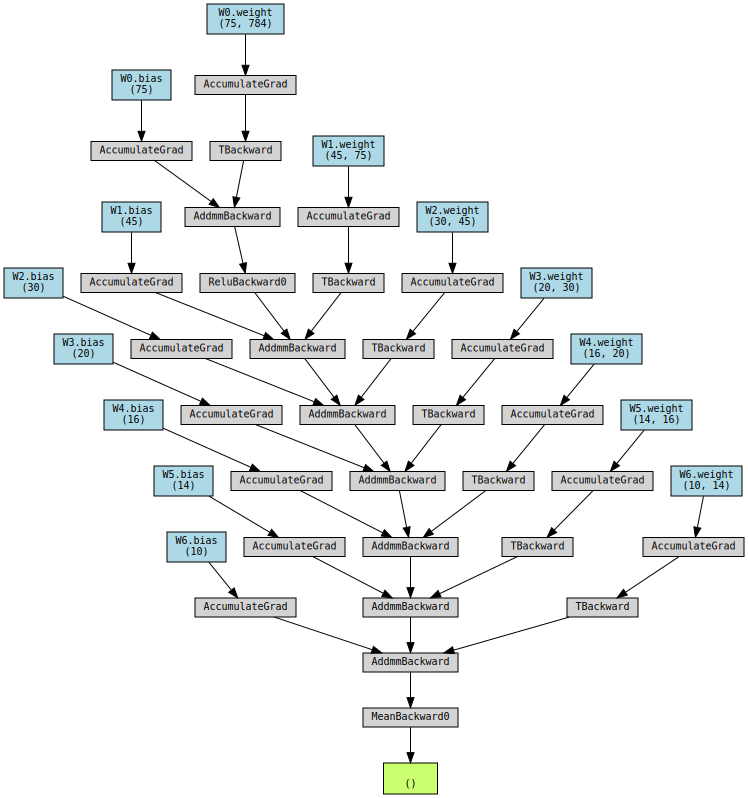

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model1 = nn.Sequential()
#model1 = model1.to(device= device)
model1.add_module('W0', nn.Linear(28*28, 75))
model1.add_module('ReLU', nn.ReLU())
model1.add_module('W1', nn.Linear(75, 45))
model1.add_module('ReLU', nn.ReLU())
model1.add_module('W2', nn.Linear(45, 30))
model1.add_module('ReLU', nn.ReLU())
model1.add_module('W3', nn.Linear(30, 20))
model1.add_module('ReLU', nn.ReLU())
model1.add_module('W4', nn.Linear(20, 16))
model1.add_module('ReLU', nn.ReLU())
model1.add_module('W5', nn.Linear(16, 14))
model1.add_module('ReLU', nn.ReLU())
model1.add_module('W6', nn.Linear(14, 10))

xx = torch.randn(32,784).to(device='cpu')
yy = model1(xx)

make_dot(yy.mean(), params=dict(model1.named_parameters()))
#make_dot(yy.mean(), params=dict(model1.named_parameters())).render("model1", format="png")